In [233]:
import sys
import json
from os import listdir
from itertools import product
import importlib
import matplotlib.pyplot as plt
import numpy as np

import input_output
importlib.reload(input_output)
import inheritance_states
importlib.reload(inheritance_states)
import transition_matrices
importlib.reload(transition_matrices)
import genotypes
importlib.reload(genotypes)
import losses
importlib.reload(losses)
import viterbi
importlib.reload(viterbi)

<module 'viterbi' from '/Users/kelley/Projects/PhasingFamilies/phase/viterbi.py'>

In [302]:
# Read in command line arguments
chrom = '21'
m = 5
ped_file = '../data/spark.ped'

data_dir = '../split_gen_spark'
param_file = '../parameter_estimation/spark_params.json'

#data_dir = '../split_gen_ihart_23andme'
#param_file = '../parameter_estimation/23andme_params.json'

#data_dir = '../split_gen_ihart_chip'
#param_file = '../parameter_estimation/ihart_chip_params.json'

batch_size = None
batch_num = None
batch_offset = None

# set up filenames
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
coord_file = '%s/chr.%s.gen.coordinates.npy' % (data_dir,  chrom)
gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s' % chrom) in f and 'gen.npz' in f])

with open(param_file, 'r') as f:
    params = json.load(f)


In [303]:
# pull families of interest
families_of_this_size = input_output.pull_families(sample_file, ped_file, m, batch_size, batch_offset)

families with sequence data 2960
families of size 5: 67
families pulled 5: 67


In [304]:
# create inheritance states
states = inheritance_states.AutosomalInheritanceStates(m)

# create transition matrix
transitions = transition_matrices.AutosomalTransitionMatrix(states, params)

# create genotypes
gens = genotypes.Genotypes(m)

522
inheritance states (522, 11)
transitions (522, 22)
genotypes (1024, 5)


In [305]:
importlib.reload(losses)
import losses

# create loss function
loss = losses.LazyLoss(states, gens, params)
#for s, l1, l2, l3, l4 in zip(states, loss((0,)*m), loss((-1,)*m), loss((-2,)*m), loss((1, 0, 1, 1, 0))):
#    print(s, l1, l2, l3, l4)

#l = loss((1, 0, 1, 1, 0))
#for s in loss.loss_states:
#    s = np.asarray(s)
#    i = states.index(tuple(s))
#    if np.any(s[:4] == 2):
#        new_state = s.copy()
#        new_state[s==2] = 1
#        state_index = states.index(tuple(new_state))
#        if l[i] != l[state_index]:
#            print(s, new_state, l[i], l[state_index])
        #print(sorted(set(loss.perfect_match_indices[loss.loss_state_to_index[tuple(s)]])))
        #print(sorted(set(loss.perfect_match_indices[loss.loss_state_to_index[tuple(new_state)]])))
#print(loss((1, 2, 1, 0)))
#print(loss.get_parental_variants((1, 1, 1, 1, 1, 0, 1, 1, 1, 0), (1, 2, 1, 0, 1)))
#print(loss.get_parental_variants((1, 1, 1, 1, 1, 0, 1, 1, 1, 0), (2, 1, 2, 1, 2)))

Prediction to best obs {0: 0, 1: 1, 2: 2, 3: 0, 4: 2, 5: -1}
	-1		0		1		2
0	2.1987-1.1987	0.0029-0.0297	3.5532-2.5532	5.4496-4.4496
1	2.0158-1.0158	3.6005-2.6005	0.0044-0.0463	3.6777-2.6777
2	2.0139-1.0139	3.6127-2.6127	3.6479-2.6479	0.0044-0.0465
3	1.3839-1.3839	0.0193-0.0284	2.6594-1.6594	7.0215-6.0215
4	1.2068-1.2068	8.5649-7.5649	1.9365-1.9365	0.0332-0.0332
5	0.0722-0.0748	0.0722-0.0748	3.2426-2.2426	1.5847-1.5847
losses (522, 1024)
perfect matches 536
perfect_match_indices (522, 16)
hts loss states 225
lc loss states 72


In [306]:
import random

# ('AU3912', 'AU3912202', 'AU3912201')

# ()'AU1453', 'AU1453202', 'AU1453201')
#fkey = ('AU1494', 'AU1494202', 'AU1494201')
#fkey = ('AU2757', 'AU2757202', 'AU2757201')
#fkey = ('AU0808', 'AU080801', 'AU080802')
#inds = [k[1] for k in families_of_this_size if k[0]==fkey][0]

fkey, inds = random.choice(families_of_this_size)
#fkey, inds = [x for x in families_of_this_size if x[0] == ('AU0012.AU001203.AU001204', 'AU001201', 'AU001202')][0]
print('family', fkey, inds)

family ('SF0005675', 'SF0005675_SP0006892', 'SF0005675_SP0020291') ['SF0005675_SP0006892', 'SF0005675_SP0020291', 'SF0005675_SP0005848', 'SF0005675_SP0005675', 'SF0005675_SP0006047']


In [307]:
import input_output
importlib.reload(input_output)

# get ready to pull processed WGS data 
wgs_data = input_output.WGSData(data_dir, gen_files, coord_file, sample_file, ped_file, chrom)

chrom shape only SNPs (8593,)


In [308]:
# pull genotype data for this family
family_genotypes, family_snp_positions, mult_factor = wgs_data.pull_data_for_individuals(inds)
print('Data pulled')

% all homref 0.6590247876178285
% all homref or missing 0.6818340509717211
n 5861
Data pulled


In [309]:
# forward sweep
v_cost = viterbi.viterbi_forward_sweep_autosomes(family_genotypes, family_snp_positions, mult_factor, states, transitions, loss)

# backward sweep
final_states = viterbi.viterbi_backward_sweep_autosomes(v_cost, states, transitions)



Forward sweep complete 3.46433424949646 sec
Num solutions (1,) 1329.7795194774621 [[1 1 1 1 0 0 1 0 1 0 1]]
Num positions in fork 13
Backward sweep complete 0.35732197761535645 sec


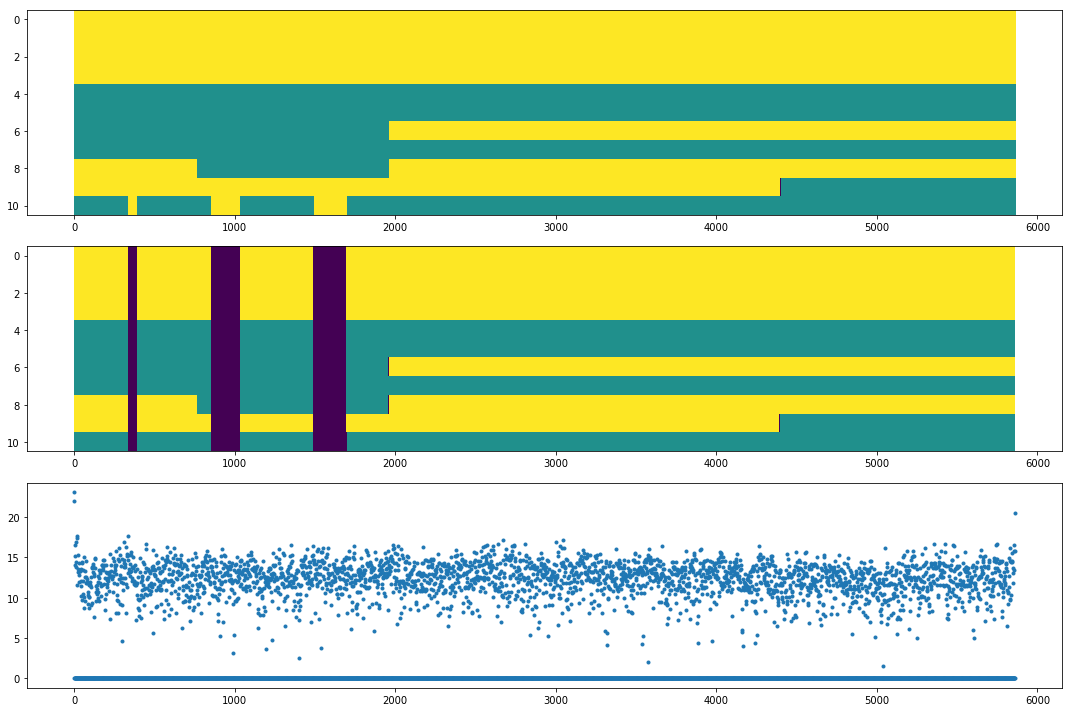

In [310]:
plt.figure(figsize=(15, 10))

ax = plt.subplot(3, 1, 1)
plt.imshow(final_states, aspect='auto', vmin=-1, vmax=1)

plt.subplot(3, 1, 2, sharex=ax)
final_states_greyed = final_states.copy()
final_states_greyed[:, final_states_greyed[-1, :]>0] = -1
plt.imshow(final_states_greyed[:, :-1], aspect='auto', vmin=-1, vmax=1)

plt.subplot(3, 1, 3, sharex=ax)
plt.plot(np.log2(family_snp_positions[:, 1]-family_snp_positions[:, 0]), marker='.', linestyle='')
plt.tight_layout()
plt.show()

In [280]:
sample_id_to_sex = input_output.pull_sex(ped_file)

print([sample_id_to_sex[x] for x in inds[2:]])


['1', '1', '1']


In [281]:

print('hard to sequence', np.sum(mult_factor * (final_states[-1, :]==1))/np.sum(mult_factor))     
print('low coverage', np.sum(mult_factor * (final_states[-1, :]==2))/np.sum(mult_factor))     

print('m1 deletion', np.sum(mult_factor * (final_states[0, :]==0))) 
print('m2 deletion', np.sum(mult_factor * (final_states[1, :]==0))) 
print('p1 deletion', np.sum(mult_factor * (final_states[2, :]==0))) 
print('p2 deletion', np.sum(mult_factor * (final_states[3, :]==0)))



hard to sequence 0.05893003427067563
low coverage 0.011843937534402563
m1 deletion 3544
m2 deletion 6959
p1 deletion 4505
p2 deletion 3669


In [282]:
anc = 1
del_start = np.where((final_states[anc, :-1]!=0) & (final_states[anc, 1:]==0))[0]+1
del_end = np.where((final_states[anc, :-1]==0) & (final_states[anc, 1:]!=0))[0]+1
#del_start = np.where((final_states[1, :-1]!=2) & (final_states[1, 1:]==2))[0]+1
#del_end = np.where((final_states[1, :-1]==2) & (final_states[1, 1:]!=2))[0]
#del_start = np.where((final_states[-1, :-1]!=1) & (final_states[-1, 1:]==1))[0]
#del_end = np.where((final_states[-1, :-1]==1) & (final_states[-1, 1:]!=1))[0]

print(len(del_start), len(del_end))

# remove deletions in hard to sequence regions
indices = np.ones((del_start.shape[0],), dtype=bool)
for i, (s, e) in enumerate(zip(del_start, del_end)):
    indices[i] = np.all(final_states[-1, s:e]==0)
print('hard to seq', np.sum(indices))
    
del_start = np.array(del_start)[indices]
del_end = np.array(del_end)[indices]
print(len(del_start), len(del_end))



18 18
hard to seq 9
9 9


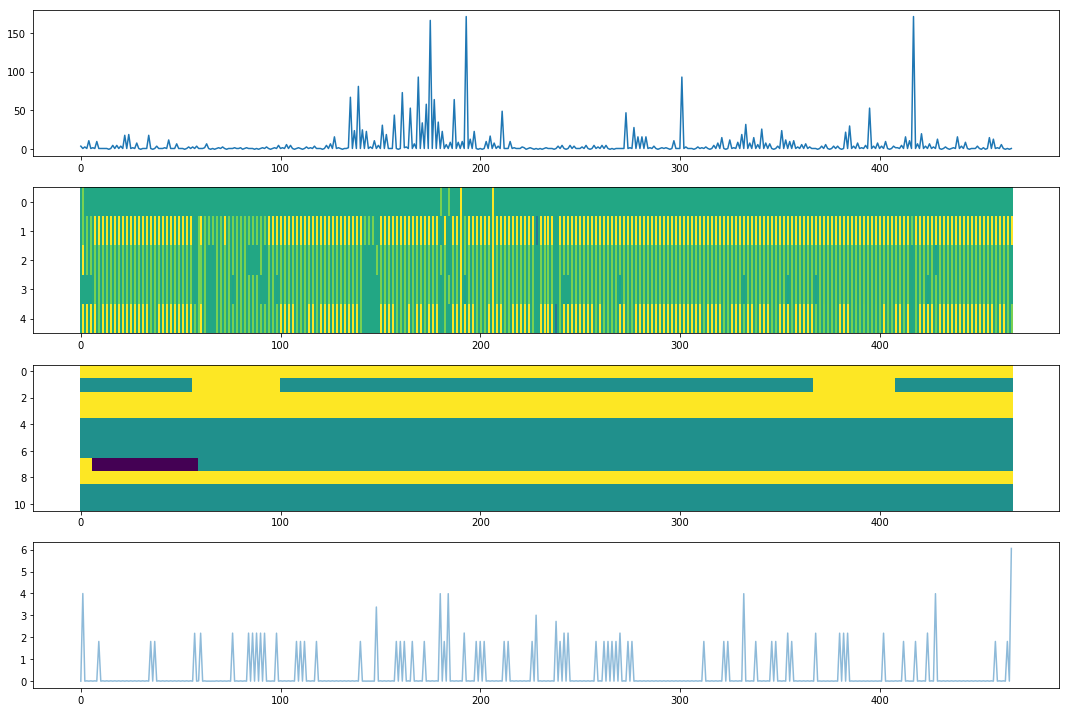

In [285]:
dstart, dend = random.choice(list(zip(del_start, del_end)))
start, end = max(0, dstart-100), min(dend+100, family_genotypes.shape[1])
#print(family_snp_positions[dstart, 0], family_snp_positions[dend, 0])
#start, end = 168156000, 168172000
#start, end = 71706745, 71715561
#start, end = 225044, 225185

#start, end = 5054906, 5058099
#start, end = np.where(family_snp_positions[:, 0]>=start)[0][0], np.where(family_snp_positions[:, 0]<=end)[0][-1]
#start, end = max(0, start-100), min(end+100, family_genotypes.shape[1])

state_indices_of_interest = []

plt.figure(figsize=(15, 10))
ax = plt.subplot(4, 1, 1)
plt.plot(mult_factor[start:end])

plt.subplot(4, 1, 2, sharex=ax)
plt.imshow(family_genotypes[:, start:end], aspect='auto', vmin=-3, vmax=2)
#plt.colorbar()

#plt.subplot(3, 1, 3)
#seg = family_genotypes[:, start:end]
#plt.imshow(seg[:, np.any(seg != -2, axis=0)], aspect='auto', vmin=-2, vmax=2)

plt.subplot(4, 1, 3, sharex=ax)
plt.imshow(final_states[:, start:end], aspect='auto', vmin=-1, vmax=1)

plt.subplot(4, 1, 4, sharex=ax)
plt.plot([loss(tuple(family_genotypes[:, j]))[states.index(tuple(np.clip(final_states[:, j], 0, None)))] for j in range(start, end)], alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index((1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0))] for j in range(start, end+1)], alpha=0.5)
#plt.plot([loss(tuple(family_genotypes[:, j]))[states.index((0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0))] for j in range(start, end+1)], alpha=0.5)


plt.tight_layout()
plt.show()

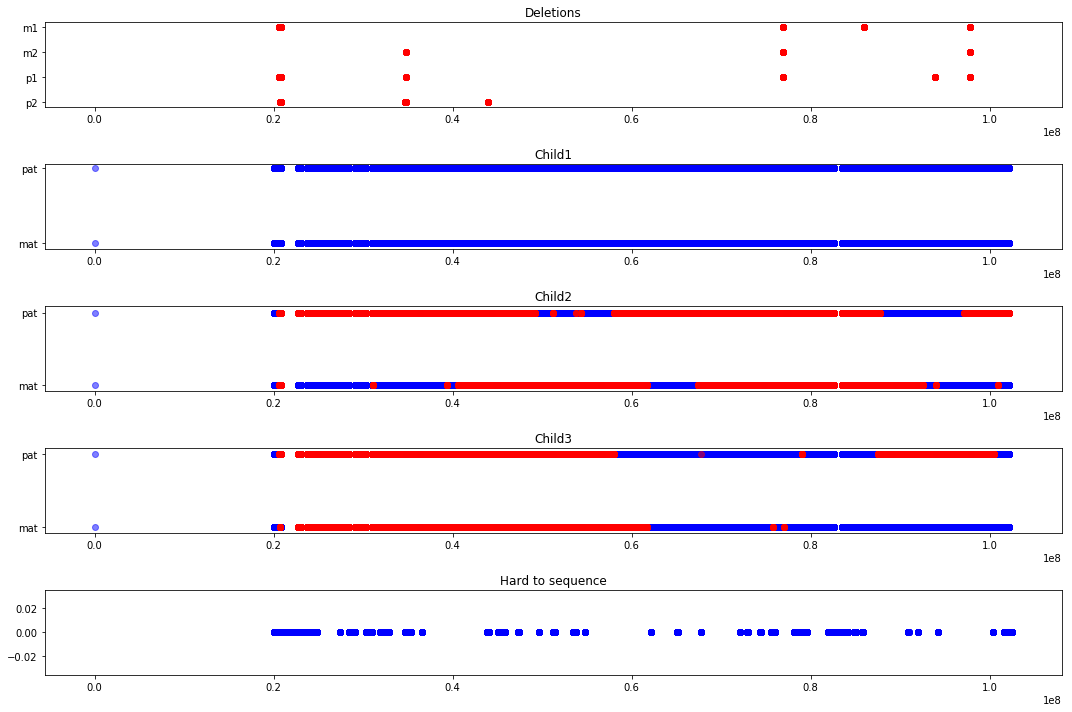

In [701]:
plt.figure(figsize=(15, 10))

ax = plt.subplot(m, 1, 1)

for i in range(4):
    #plt.scatter(family_snp_positions[final_states_greyed[i, :] == -1, 0], np.repeat(3-i, np.sum(final_states_greyed[i, :] == -1)), color='blue', alpha=0.5)
    plt.scatter(family_snp_positions[final_states_greyed[i, :] == 0, 0], np.repeat(3-i, np.sum(final_states_greyed[i, :] == 0)), color='red', alpha=0.5)
plt.title('Deletions')
plt.yticks(range(3, -1, -1), ['m1', 'm2', 'p1', 'p2'])

for i in range(0, m-2):
    plt.subplot(m, 1, i+2, sharex=ax)
    indices = (final_states_greyed[4+(2*i), :] == 0) & (final_states_greyed[-1, :] == 0)
    plt.scatter(family_snp_positions[indices, 0], np.repeat(0, np.sum(indices)), color='blue', alpha=0.5)
    indices = (final_states_greyed[4+(2*i), :] == 1) & (final_states_greyed[-1, :] == 0)
    plt.scatter(family_snp_positions[indices, 0], np.repeat(0, np.sum(indices)), color='red', alpha=0.5)

    indices = (final_states_greyed[5+(2*i), :] == 0) & (final_states_greyed[-1, :] == 0)
    plt.scatter(family_snp_positions[indices, 0], np.repeat(1, np.sum(indices)), color='blue', alpha=0.5)
    indices = (final_states_greyed[5+(2*i), :] == 1) & (final_states_greyed[-1, :] == 0)
    plt.scatter(family_snp_positions[indices, 0], np.repeat(1, np.sum(indices)), color='red', alpha=0.5)

    plt.title('Child%d' % (i+1))
    plt.yticks(range(0, 2), ['mat', 'pat'])

plt.subplot(m, 1, m, sharex=ax)
plt.scatter(family_snp_positions[final_states_greyed[-1, :] == -1, 0], np.repeat(0, np.sum(final_states_greyed[-1, :] == -1)), color='blue', alpha=0.5)
plt.scatter(family_snp_positions[final_states_greyed[-1, :] == 1, 0], np.repeat(0, np.sum(final_states_greyed[-1, :] == 1)), color='red', alpha=0.5)
plt.title('Hard to sequence')

plt.tight_layout()
plt.show()



In [26]:
print(family_snp_positions[start, :], family_snp_positions[end, :])

[34716560 34716561] [34765024 34765025]


In [403]:
import numpy as np
def estimate_parental_variants(final_states, family_genotypes):
    m, n = family_genotypes.shape
    parental_variants, cost, blame = -np.ones((4, n), dtype=np.int8), -np.ones((n,), dtype=int), -np.ones((m, n), dtype=float)
    has_missing = 0
    for i in range(n):
        state, gen = final_states[:, i], tuple(family_genotypes[:, i])
        
        missing_indices = [i for i, x in enumerate(state) if x==-1]
        
        if len(missing_indices) == 0:
            pv, v, b = loss.get_parental_variants(tuple(state), gen)
            parental_variants[:, i] = pv
            cost[i] = v
            blame[:, i] = b
        else:
            has_missing += 1
            all_possible_states = np.tile(state, (pow(2, len(missing_indices)), 1))
            all_possible_states[:, missing_indices] = list(product(*[[0, 1]]*len(missing_indices)))

            min_v = None
            all_pvs, all_bs = [], []
            for s in all_possible_states:
                pv, v, b = loss.get_parental_variants(tuple(s), gen)
                if min_v is None or v < min_v:
                    min_v = v
                    all_pvs, all_bs = [pv], [b]
                elif v == min_v:
                    all_pvs.append(pv)
                    all_bs.append(b)

            all_pvs, all_bs = np.asarray(all_pvs), np.asarray(all_bs)
            parental_variants[np.all(all_pvs==-2, axis=0), i] = -2
            parental_variants[np.all(all_pvs==0, axis=0), i] = 0
            parental_variants[np.all(all_pvs==1, axis=0), i] = 1
            cost[i] = min_v
            
            all_bs = np.sum(all_bs, axis=0)
            if min_v == 0:
                blame[:, i] = 0
            else:
                blame[:, i] = min_v*all_bs/np.sum(all_bs)
            
        if i%10000==0:
            print(i, has_missing)
    return parental_variants, cost, blame

parental_variants, cost, blame = estimate_parental_variants(states, family_genotypes)       

AttributeError: 'LazyLoss' object has no attribute 'get_parental_variants'

In [404]:
import time
import numpy as np
from itertools import product

def mask_states(family_genotypes, mult_factor, final_states, inheritance_states, loss, error_rate=0.001, smooth=5000):

	masked_final_states = np.copy(final_states)
	# Now, do masking
	prev_time = time.time()
	m, n = family_genotypes.shape
	p, state_len = inheritance_states.p, inheritance_states.state_len

	fit = -np.ones((n,), dtype=int)
	prev_state = None
	prev_state_indices = None
	for j in range(n): 
		pos_gen = tuple(family_genotypes[:, j])
		current_state = tuple(final_states[:, j])

		if current_state != prev_state:
			prev_state = current_state
			num_unknowns = len([x for x in current_state if x == -1])
			if num_unknowns>0:
				prev_state_indices = []
				for poss_itr in [iter(x) for x in product(*([[0, 1]]*num_unknowns))]:
					poss_state = tuple([x if x != -1 else next(poss_itr) for x in current_state])
					prev_state_indices.append(inheritance_states.index(poss_state))
			else:
				prev_state_indices = [inheritance_states.index(tuple(final_states[:, j]))]

		fit[j] = mult_factor[j]*(np.min(loss(pos_gen)[prev_state_indices])==1)
        
	print(np.unique(fit, return_counts=True))


	c = np.convolve(fit/m, np.ones(smooth,), mode='same')
	masked = (c>(error_rate*smooth)).astype(np.int8)
	print('Percent masked', 100*np.sum(masked)/n)

	# if a parental chromosome isn't inherited, then we don't know if it has a deletion
	maternal_indices = range(4, state_len, 2)
	paternal_indices = range(5, state_len, 2)

	m1_ninh = np.all(final_states[maternal_indices, :]!=0, axis=0)
	m2_ninh = np.all(final_states[maternal_indices, :]!=1, axis=0)
	p1_ninh = np.all(final_states[paternal_indices, :]!=0, axis=0)
	p2_ninh = np.all(final_states[paternal_indices, :]!=1, axis=0)

	masked_final_states[0, m1_ninh] = -1
	masked_final_states[1, m2_ninh] = -1
	masked_final_states[2, p1_ninh] = -1
	masked_final_states[3, p2_ninh] = -1
	masked_final_states = np.append(masked_final_states, masked[np.newaxis, :], axis=0)
	print('Percent never inherited', 100*np.sum(m1_ninh)/n, 100*np.sum(m2_ninh)/n, 100*np.sum(p1_ninh)/n, 100*np.sum(p2_ninh)/n)

	print('Masking complete', time.time()-prev_time, 'sec') 
	return masked_final_states, c

In [405]:
# mask messy areas
masked_final_states, f = mask_states(family_genotypes, mult_factor, final_states, inheritance_states, loss, error_rate=0.01)
#masked_final_states[:, masked_final_states[-1, :]==1] = -1

AttributeError: module 'inheritance_states' has no attribute 'p'

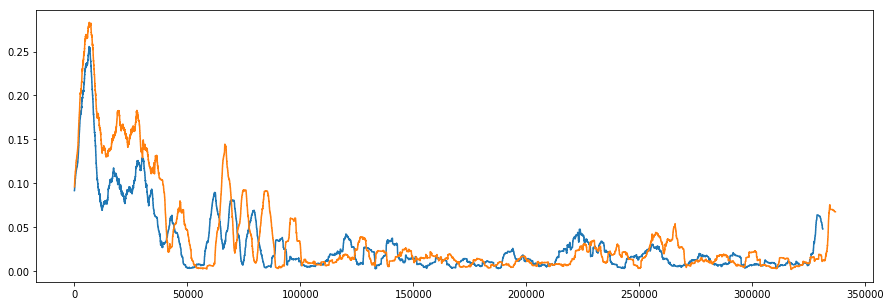

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(f/1000)
plt.plot(overall)
plt.show()

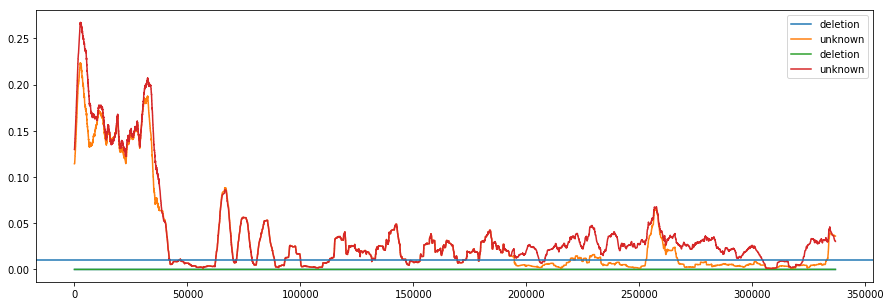

In [356]:
smooth=5000
c = np.convolve(np.sum(parental_variants==-2, axis=0), np.ones(smooth,), mode='same')/(smooth*m)
d = np.convolve(np.sum(parental_variants==-1, axis=0), np.ones(smooth,), mode='same')/(smooth*m)

plt.figure(figsize=(15, 5))
plt.plot(a, label='deletion')
plt.plot(b, label='unknown')
plt.plot(c, label='deletion')
plt.plot(d, label='unknown')
#plt.plot(overall)
#plt.ylim([0, 0.1])
plt.axhline(0.01)
plt.legend()
plt.show()

In [301]:
print(np.sum(parental_variants==-1)/(4*parental_variants.shape[1]))

0.03845131889500794


In [358]:
print(np.sum(blame==0)/(blame.shape[0]*blame.shape[1]))
print(np.sum(parental_variants==0)/(parental_variants.shape[0]*parental_variants.shape[1]))


0.9585785325159203
0.7399936170528597


In [375]:
pos_lens = family_snp_positions[:, 1]-family_snp_positions[:, 0]
print(pos_lens.shape)
print(np.sum(parental_variants!=0))
print(np.sum(mult_factor*np.sum(parental_variants!=0, axis=0)))
print(np.sum(mult_factor[np.any(parental_variants!=0, axis=0)]))

(336835,)
350317
356837
162726


In [396]:
import scipy.sparse as sparse

chrom_length = chrom_lengths[chrom]
nonzeros = np.sum(mult_factor*np.sum(parental_variants!=0, axis=0))
data = np.zeros((nonzeros,), dtype=np.int8)
row_ind = np.zeros((nonzeros,), dtype=int)
col_ind = np.zeros((nonzeros,), dtype=int)

data_index = 0
for i, j in zip(*np.nonzero(parental_variants)):
    pos_start, pos_end = family_snp_positions[j, :]
    pos_length = pos_end - pos_start
    
    data[data_index:(data_index+pos_length)] = parental_variants[i, j]
    row_ind[data_index:(data_index+pos_length)] = i
    col_ind[data_index:(data_index+pos_length)] = range(pos_start, pos_end)
    data_index += pos_length

parental_variants_csc = sparse.csc_matrix((data, (row_ind, col_ind)), shape=(4, chrom_length))

In [397]:
print(np.nonzero(parental_variants)[0].shape)
print(data[:5])
print(parental_variants_csc.nnz)

(350317,)
[-1 -1 -1 -1  1]
356837


In [420]:
import random
j = random.choice(np.where(mult_factor*np.any(parental_variants!=0, axis=0)>1)[0])
print(j, family_snp_positions[j, :])
print(parental_variants[:, j])
print(parental_variants_csc[:, family_snp_positions[j, 0]:family_snp_positions[j, 1]])

135896 [47401860 47401862]
[ 0  0  0 -1]
  (3, 0)	-1
  (3, 1)	-1


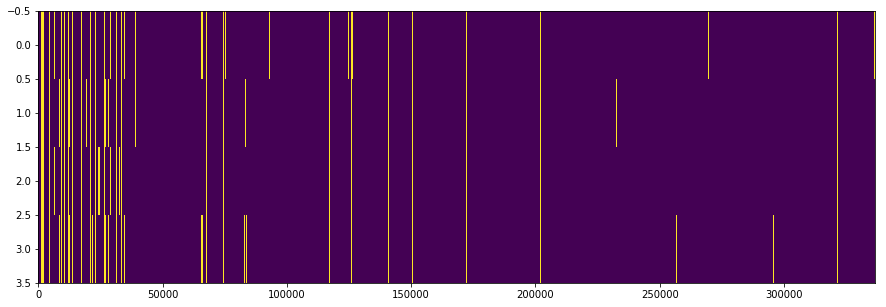

In [325]:
plt.figure(figsize=(15, 5))
plt.imshow((parental_variants==-1)[:1000], aspect='auto')
plt.show()

In [94]:
smooth=5000
mo = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth
overall = np.convolve(np.sum(blame, axis=0), np.ones(smooth,), mode='same')/smooth

ValueError: all the input array dimensions except for the concatenation axis must match exactly

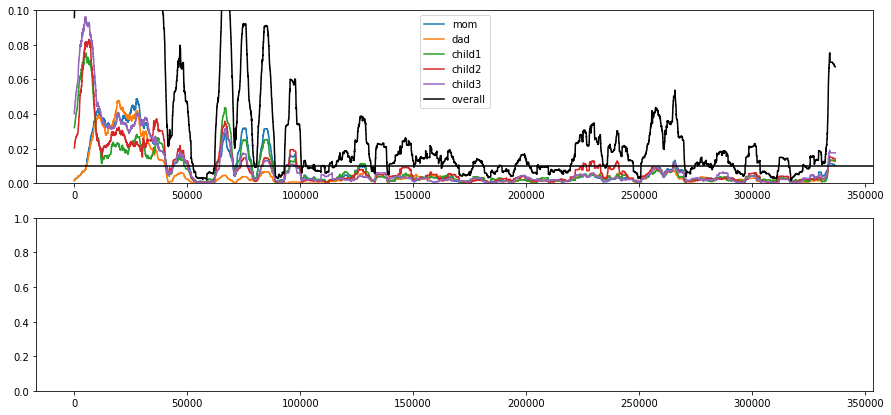

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

ax1 = plt.subplot(2, 1, 1)
plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
plt.plot(overall, label='overall', color='black')
plt.axhline(0.01, color='black')
plt.legend()
plt.ylim([0, 0.1])

all_convolve = np.vstack((mo, d, c1, c2, c3))

plt.subplot(2, 1, 2, sharex=ax1)
plt.imshow(np.vstack((masked_final_states[-1, :], np.sum(all_convolve>0.01, axis=0)>1)), aspect='auto')

plt.show()

array([4, 4, 4, ..., 2, 2, 2])

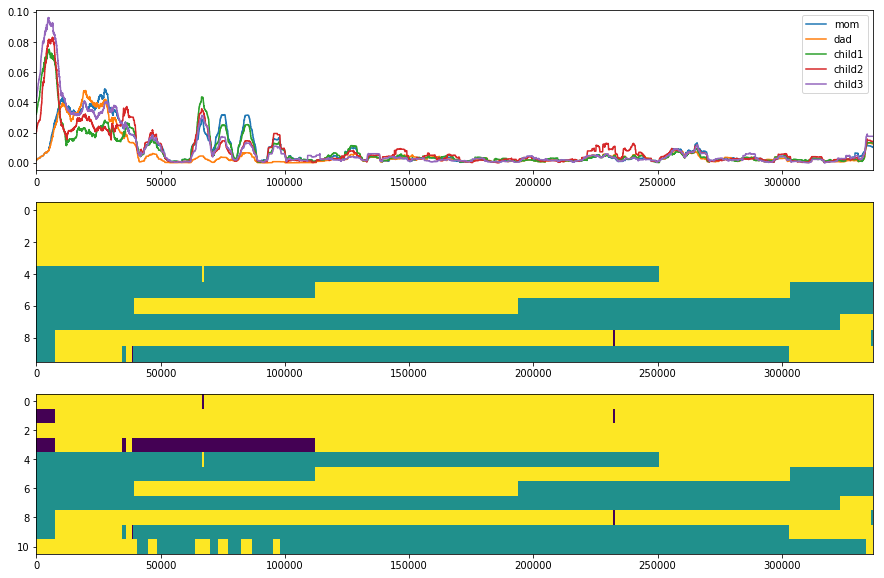

In [101]:

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(3, 1, 1)
plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
#plt.plot(b)
plt.legend()

plt.subplot(3, 1, 2, sharex=ax1)
plt.imshow(final_states, aspect='auto')

plt.subplot(3, 1, 3, sharex=ax1)
plt.imshow(masked_final_states, aspect='auto')

plt.show()

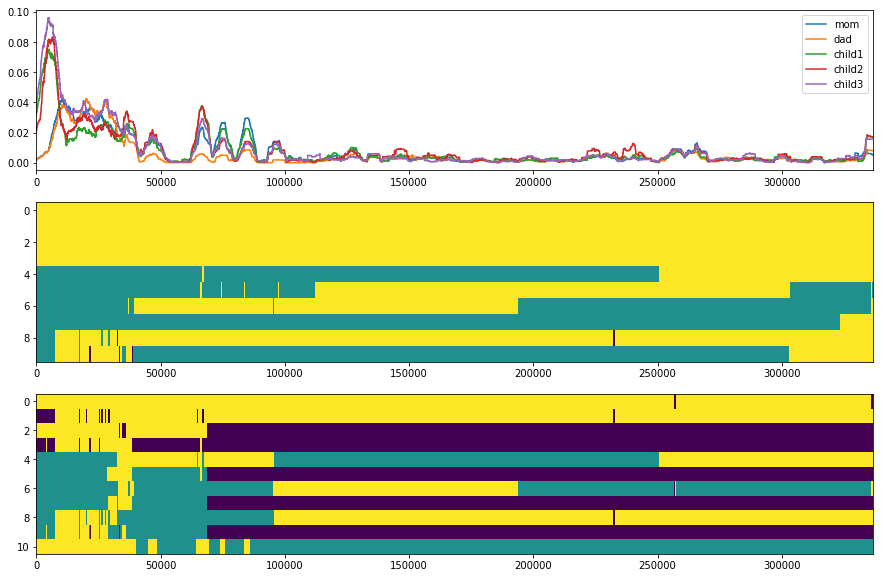

In [114]:
smooth=5000
mo = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth
overall = np.convolve(np.sum(blame, axis=0), np.ones(smooth,), mode='same')/smooth

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(3, 1, 1)
plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
#plt.plot(b)
plt.legend()

plt.subplot(3, 1, 2, sharex=ax1)
plt.imshow(final_states, aspect='auto')

plt.subplot(3, 1, 3, sharex=ax1)
plt.imshow(masked_final_states, aspect='auto')

plt.show()

In [280]:
m = 5
smooth = 5000

In [289]:
# family-wise unphased mendelian
unique_gens, indices = np.unique(family_genotypes, axis=1, return_inverse=True)

parents_to_children_with_del = {
    (-1, -1): [-1],
    (-1, 0): [-1, 0],
    (-1, 1): [0, 2],
    (-1, 2): [-1, 2],
    (0, 0): [-1, 0],
    (0, 1): [0, 1, 2],
    (0, 2): [-1, 0, 1, 2],
    (1, 1): [0, 1, 2],
    (1, 2): [0, 1, 2],
    (2, 2): [-1, 2]
    
}

parents_to_children_without_del = {
    (0, 0): [0],
    (0, 1): [0, 1],
    (0, 2): [1],
    (1, 1): [0, 1, 2],
    (1, 2): [1, 2],
    (2, 2): [2]
    
}
parental_genotypes = list(product(*[[0, 1, 2]]*2))

# without del
trio_perfect_match_gens_nodel = set()
trios_could_be_mendelian = np.zeros((family_genotypes.shape[1],), dtype=int)
for pg in parental_genotypes:
    trio_perfect_match_gens_nodel.update([pg + cg for cg in product(*[parents_to_children_without_del[(min(pg), max(pg))]]*(m-2))])

for i, gen in enumerate(unique_gens.T):
    missing_indices = [i for i, x in enumerate(gen) if x==-1]
    all_possible_gens = np.tile(gen, (pow(4, len(missing_indices)), 1))
    all_possible_gens[:, missing_indices] = list(product(*[[-1, 0, 1, 2]]*len(missing_indices)))
    #print(all_possible_gens)
    
    if np.any([tuple(g) in trio_perfect_match_gens_nodel for g in all_possible_gens]):
        trios_could_be_mendelian[indices==i] = 1



In [290]:
print(len(trio_perfect_match_gens_del), len(trio_perfect_match_gens_nodel))

279 63


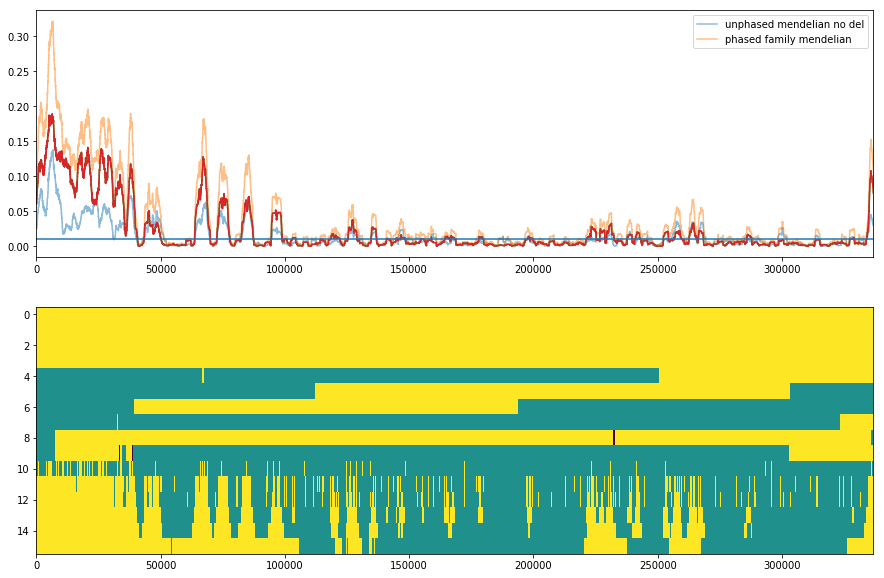

In [312]:
smooth = 500*4
smoothed_cost = np.convolve(cost>0, np.ones(smooth,), mode='same')/smooth
smoothed_md_nodel = np.convolve(1-trios_could_be_mendelian, np.ones(smooth,), mode='same')/smooth
smoothed_final = np.convolve((cost>0) - 1 + trios_could_be_mendelian, np.ones(smooth,), mode='same')/smooth

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 1, 1)
plt.plot(smoothed_md_nodel, label='unphased mendelian no del', alpha=0.5)
plt.plot(smoothed_cost, label='phased family mendelian', alpha=0.5)
plt.plot(smoothed_cost-smoothed_md_nodel)
plt.plot(smoothed_final)

#plt.plot(mo, label='mom')
#plt.plot(d, label='dad')
#plt.plot(c1, label='child1')
#plt.plot(c2, label='child2')
#plt.plot(c3, label='child3')
plt.axhline(0.01)
plt.legend()

to_plot = []
for smooth in [1, 50, 100, 500, 1000, 5000]:
    smooth = smooth*4
    smoothed_cost = np.convolve(cost>0, np.ones(smooth,), mode='same')/smooth
    smoothed_md_nodel = np.convolve(1-trios_could_be_mendelian, np.ones(smooth,), mode='same')/smooth
    to_plot.append(smoothed_cost-smoothed_md_nodel>0.01)


plt.subplot(2, 1, 2, sharex=ax1)
plt.imshow(np.vstack((final_states, to_plot[0], to_plot[1], to_plot[2], to_plot[3], to_plot[4], to_plot[5])), aspect='auto')

plt.show()

In [321]:
print(np.sum(1-trios_could_be_mendelian)/2/trios_could_be_mendelian.shape)
print(np.sum(cost>0)/2/cost.shape)
print((np.sum(parental_variants[:, cost==0]==-1) + m*np.sum(cost!=0))/2/(m*cost.shape[0]))

[0.00697077]
[0.01793608]
0.02854750842400582


[0.24834118]


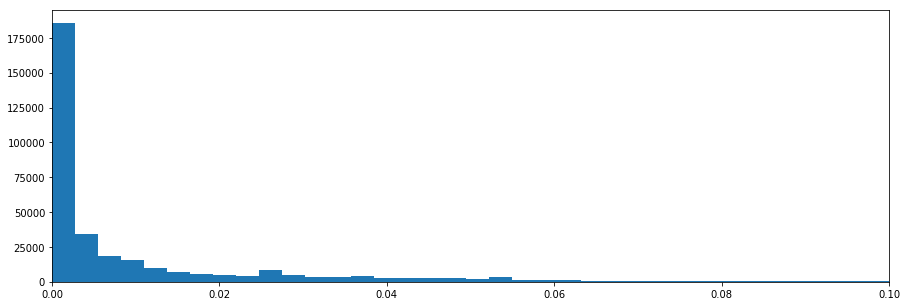

In [278]:
print(np.sum(smoothed_md_del > 0.01)/smoothed_md_del.shape)

plt.figure(figsize=(15, 5))
plt.hist(smoothed_md_del, bins=70)
plt.xlim([0, 0.1])
plt.show()

In [ ]:

smooth=5000
#mo = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
#d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
#c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
#c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
#c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth
#overall = np.convolve(np.sum(blame, axis=0), np.ones(smooth,), mode='same')/smooth



plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 1, 1)
plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
#plt.plot(b)
plt.legend()

plt.subplot(2, 1, 2, sharex=ax1)
plt.imshow(final_states, aspect='auto')

plt.show()

In [241]:
print(np.sum(blame[0, :]==1), np.sum(blame[1, :]==1))
print(np.sum(blame[2, :]==1), np.sum(blame[3, :]==1), np.sum(blame[4, :]==1))

245 230
2879 2354 2885


In [ ]:
print('hello')

In [ ]:
smooth=500
mo = np.convolve(blame[0, :], np.ones(smooth,), mode='same')/smooth
d = np.convolve(blame[1, :], np.ones(smooth,), mode='same')/smooth
c1 = np.convolve(blame[2, :], np.ones(smooth,), mode='same')/smooth
c2 = np.convolve(blame[3, :], np.ones(smooth,), mode='same')/smooth
c3 = np.convolve(blame[4, :], np.ones(smooth,), mode='same')/smooth


plt.figure(figsize=(15, 5))

plt.plot(mo, label='mom')
plt.plot(d, label='dad')
plt.plot(c1, label='child1')
plt.plot(c2, label='child2')
plt.plot(c3, label='child3')
plt.legend()
plt.show()

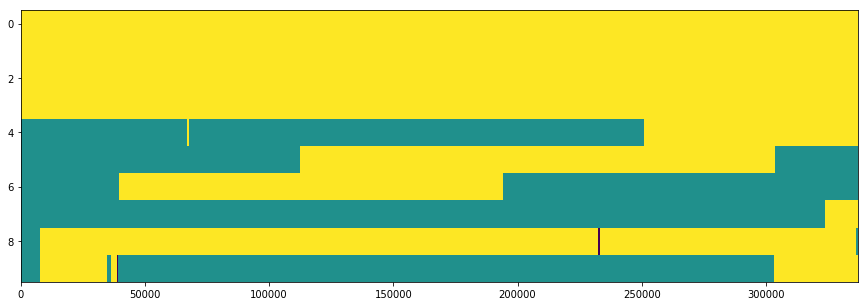

34


In [90]:
plt.figure(figsize=(15, 5))
plt.imshow(final_states, aspect='auto')
plt.show()
print(np.sum(np.any(final_states[:, 1:] != final_states[:, :-1], axis=0)))

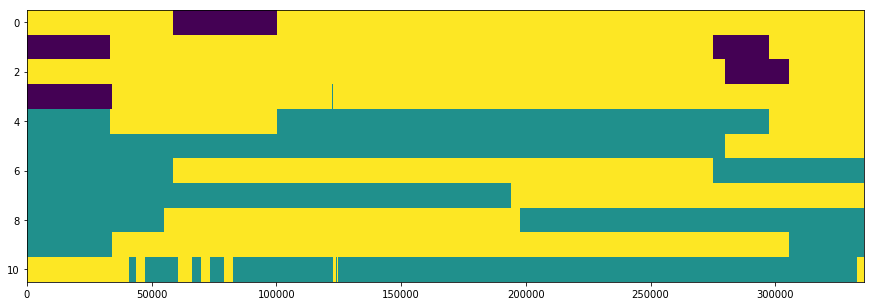

40


In [201]:
plt.figure(figsize=(15, 5))
plt.imshow(masked_final_states, aspect='auto')
plt.show()
print(np.sum(np.any(masked_final_states[4:, 1:] != masked_final_states[4:, :-1], axis=0)))

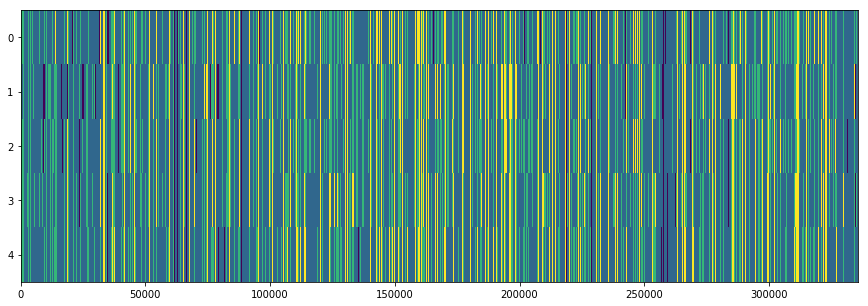

In [181]:
plt.figure(figsize=(15, 5))
plt.imshow(family_genotypes[:50000, :], aspect='auto')
plt.show()


In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(final_states, aspect='auto')
plt.show()


In [ ]:
import numpy as np
print(np.sum((family_genotypes[2, :]==1) & (family_genotypes[[0, 1, 3], :]==0)))
print(np.sum((family_genotypes[3, :]==1) & (family_genotypes[[0, 1, 2], :]==0)))

In [ ]:
print(wgs_data.chrom_length)

In [ ]:
93326/family_genotypes.shape[1]

In [ ]:
print(np.sum((family_genotypes[2, :]==1) & np.all(family_genotypes[[0, 1, 3], :]==0, axis=0))/family_genotypes.shape[1])
print(np.sum((family_genotypes[3, :]==1) & np.all(family_genotypes[[0, 1, 2], :]==0, axis=0))/family_genotypes.shape[1])

In [ ]:
print(np.sum(np.all(family_genotypes==0, axis=0))/family_genotypes.shape[1])